# LOG6302A — Analyse d’applications et Cyber-sécurité<br>Laboratoire #6

**Quentin Guidée (2206809), Nam Vu (2230468)**

Polytechnique Montréal – Hiver 2024


## Imports et helpers

In [42]:
import tempfile
from collections import defaultdict
from itertools import product
from pathlib import Path

import numpy as np
from graphviz import Source
from IPython.display import Image

from code_analysis import AST, AST_fragmentation, ASTReader, Graph

In [43]:
def show_graph(graph: Graph):
    """Afficher le graphe dans Jupyter"""
    dot = graph.to_dot()
    s = Source(dot)
    with tempfile.NamedTemporaryFile(suffix=".png") as f:
        s.render(f.name, format="png")
        display(Image(f.name + ".png"))

## Prise en main

In [44]:
reader = ASTReader()
path_ast = Path("ast")


def get_kits():
    return [dir_kit for dir_kit in path_ast.iterdir() if dir_kit.is_dir()]


def get_kit_asts(kit: Path):
    return {file: reader.read_ast(file.as_posix()) for file in kit.glob("**/*.ast.*")}


all_kits_asts = {kit: get_kit_asts(kit) for kit in get_kits()}

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.344647 to fit


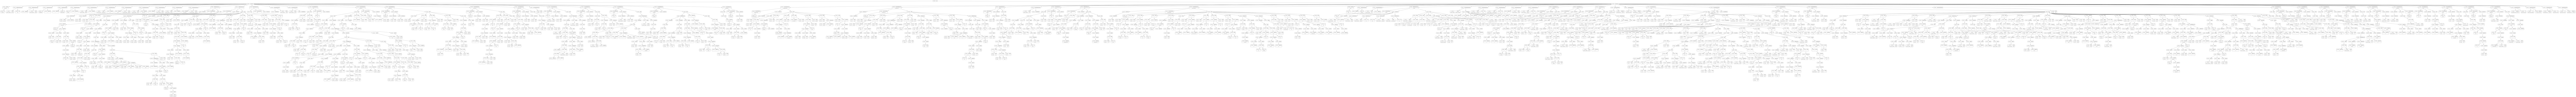

In [45]:
sample_ast = list(list(all_kits_asts.values())[40].values())[0]
show_graph(sample_ast)

In [46]:
sample_ast.vectorize()

array([  0,   0,   0,   0, 122, 220,   0,   0,  33,  74, 302,  70,   0,
         0,   0,   0,   0,   5,   0,   0,   4,   2,   2,   0,  51,   9,
         9,   9,  10,   0,   0,   0,   0,   0,   3,   0,   0,   2,   2,
         0,   0,   5,   0,   1,   2,  78,   0,   0,   0,   0,   0, 263,
         0,   2,  10,  22,   0,   0,   0,   1,   1,   3,   0,  62,   0,
         0,   0,   6,   0,  44,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   5,  36,   0,   0,   7,   3,   0,   0,  19,  31,   0,   0,
         0,   0,   2,   5,   0,  23,   0,   0,  39,   0,   0,   0,  36,
         1,  54,   0,   2,  11, 167,   0,   0,   0,   6,   0,   0,   0,
        16,   0,   0,   0,   0,  41, 528,   0,   0,   2])

In [47]:
AST_fragmentation(sample_ast)

[1132065620,
 1132065601,
 1132065536,
 1132065400,
 1132065339,
 1132065284,
 1132065483,
 1132065464,
 1132065417,
 1132065102,
 1132065078,
 1132065067,
 1132064942,
 1132063547,
 1132063662,
 1132063317,
 1132063300,
 1132063248,
 1132063479,
 1132063200,
 1132064629,
 1132064608,
 1132064563,
 1132064729,
 1132064700,
 1132064679,
 1132064657,
 1132064640,
 1132064492,
 1132064475,
 1132064466,
 1132064433,
 1132064418,
 1132064401,
 1132063969,
 1132063944]

## Partie 1 : Fichiers

### Clones paramétriques

In [48]:
def parametric_file_groups(all_kits_asts: dict[Path, dict[Path, AST]]):
    vector_groups = defaultdict[tuple[int, ...], list[Path]](list)

    for kit in all_kits_asts.values():
        for file_path, ast in kit.items():
            if len(ast.get_node_ids()) >= 100:
                vector_groups[tuple(ast.vectorize())].append(file_path)

    return vector_groups

In [49]:
groups = parametric_file_groups(all_kits_asts)
groups = list(groups.values())
groups.sort(key=len, reverse=True)
cluster = groups[0]
len(cluster), cluster

(47,
 [PosixPath('ast/4417/rabo2020/def/pin/index.php.ast.json.gz'),
  PosixPath('ast/4417/rabo2020/def/info/index.php.ast.json.gz'),
  PosixPath('ast/2099/dhl/a1b2c3/5b311143a3244728d432f81fe755d7aa/start/index.php.ast.json.gz'),
  PosixPath('ast/2099/dhl/a1b2c3/5b311143a3244728d432f81fe755d7aa/info/index.php.ast.json.gz'),
  PosixPath('ast/2099/dhl/a1b2c3/5b311143a3244728d432f81fe755d7aa/cc/index.php.ast.json.gz'),
  PosixPath('ast/2099/dhl/a1b2c3/2284e439f95ccee06d62fa62fb0f1b6f/start/index.php.ast.json.gz'),
  PosixPath('ast/2099/dhl/a1b2c3/2284e439f95ccee06d62fa62fb0f1b6f/info/index.php.ast.json.gz'),
  PosixPath('ast/2099/dhl/a1b2c3/2284e439f95ccee06d62fa62fb0f1b6f/cc/index.php.ast.json.gz'),
  PosixPath('ast/2099/dhl/a1b2c3/9bfe1de0245319b7c25a09cc5d44ece1/start/index.php.ast.json.gz'),
  PosixPath('ast/2099/dhl/a1b2c3/9bfe1de0245319b7c25a09cc5d44ece1/info/index.php.ast.json.gz'),
  PosixPath('ast/2099/dhl/a1b2c3/9bfe1de0245319b7c25a09cc5d44ece1/cc/index.php.ast.json.gz'),
  Pos

En ignorant les vecteurs dupliqués au sein d’un même kit :

In [50]:
def parametric_file_groups_deduped(all_kits_asts: dict[Path, dict[Path, AST]]):
    vector_groups = defaultdict[tuple[int, ...], list[Path]](list)

    for kit in all_kits_asts.values():
        dedup = set[tuple[int, ...]]()
        for file_path, ast in kit.items():
            if len(ast.get_node_ids()) >= 100:
                vec = tuple(ast.vectorize())
                if vec not in dedup:
                    vector_groups[vec].append(file_path)
                    dedup.add(vec)

    return vector_groups

In [51]:
groups = parametric_file_groups_deduped(all_kits_asts)
groups = list(groups.values())
groups.sort(key=len, reverse=True)
cluster = groups[0]
len(cluster), cluster

(7,
 [PosixPath('ast/3135/hunting/antibot/anti8.php.ast.json.gz'),
  PosixPath('ast/1442/web/auth/Bots/anti8.php.ast.json.gz'),
  PosixPath('ast/1110/submit/prevents/anti8.php.ast.json.gz'),
  PosixPath('ast/0485/we logz sure/anti/anti8.php.ast.json.gz'),
  PosixPath('ast/0415/M&T/darkx/anti8.php.ast.json.gz'),
  PosixPath('ast/3662/usps-shippment/bots/anti8.php.ast.json.gz'),
  PosixPath('ast/3716/gruposantander/xJOESTAR/anti8.php.ast.json.gz')])

### Fichiers simillaires

In [52]:
def vectorize_kit_asts(all_kits_asts: dict[Path, dict[Path, AST]]):
    ast_vectors: dict[Path, np.ndarray] = {}

    for kit in all_kits_asts.values():
        for file_path, ast in kit.items():
            if len(ast.get_node_ids()) >= 100:
                ast_vectors[file_path] = ast.vectorize()

    return ast_vectors

In [53]:
ast_vectors = vectorize_kit_asts(all_kits_asts)
ast_vectors

{PosixPath('ast/2620/absa/php/continue3.php.ast.json.gz'): array([ 0,  0,  0,  0, 22, 24,  0,  0,  5, 15, 55,  6,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0, 17,  0,  0,  0,  0,  0,
        18,  0,  0,  3,  0,  0,  1,  1,  0,  0,  0,  0,  2,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
         0,  0,  1,  6,  0,  0, 23, 33,  0,  0,  0,  0,  0,  0,  0,  2,  0,
         0,  0,  0,  0, 70,  0,  0,  0]),
 PosixPath('ast/2620/absa/php/continue4.php.ast.json.gz'): array([ 0,  0,  0,  0, 25, 35,  0,  0,  5, 14, 56,  6,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0,
        21,  0,  0,  3,  0,  0,  1,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,
      

In [54]:
def similar_groups[T](ast_vectors: dict[T, np.ndarray], threshold: float):
    similarities = defaultdict[T, list[T]](list)

    for (i, vector_i), (j, vector_j) in product(ast_vectors.items(), repeat=2):
        if i == j:
            continue
        if np.abs(vector_j - vector_i).sum() <= threshold * np.sum(vector_i):
            similarities[i].append(j)

    return similarities

In [55]:
groups = similar_groups(ast_vectors, 0.3)
groups = list(groups.values())
groups.sort(key=len, reverse=True)
cluster = groups[0]
len(cluster), cluster

(80,
 [PosixPath('ast/2110/moneylion/def/token/index - Copy.php.ast.json.gz'),
  PosixPath('ast/2110/moneylion/def/wifi/index.php.ast.json.gz'),
  PosixPath('ast/2110/moneylion/def/read/index.php.ast.json.gz'),
  PosixPath('ast/2110/moneylion/def/token2/index.php.ast.json.gz'),
  PosixPath('ast/2110/moneylion/def/token3/index.php.ast.json.gz'),
  PosixPath('ast/2110/moneylion/def/cc/index.php.ast.json.gz'),
  PosixPath('ast/2110/moneylion/def/login/index.php.ast.json.gz'),
  PosixPath('ast/4417/rabo2020/a1b2c3/8ed3cd96687bb07c77db299054948df1/token/index.php.ast.json.gz'),
  PosixPath('ast/4417/rabo2020/a1b2c3/8ed3cd96687bb07c77db299054948df1/done/index.php.ast.json.gz'),
  PosixPath('ast/4417/rabo2020/a1b2c3/8ed3cd96687bb07c77db299054948df1/login/index.php.ast.json.gz'),
  PosixPath('ast/4417/rabo2020/a1b2c3/44a24055e71e417ccebb479ccef7bacf/token/index.php.ast.json.gz'),
  PosixPath('ast/4417/rabo2020/a1b2c3/44a24055e71e417ccebb479ccef7bacf/done/index.php.ast.json.gz'),
  PosixPath('a

## Partie 2 : Fragments

### Clones paramétriques

In [62]:
def parametric_fragment_groups(all_kits_asts: dict[Path, dict[Path, AST]]):
    vector_groups = defaultdict[tuple[int, ...], list[tuple[Path, str]]](list)

    for kit in all_kits_asts.values():
        dedup = set[tuple[int, ...]]()
        for file_path, ast in kit.items():
            fragments: list[int] = AST_fragmentation(ast)
            fragments.append(ast.get_root())  # prendre en compte le root aussi
            for fragment in fragments:
                if len(ast.dfs(fragment)) >= 10:
                    vec = tuple(ast.vectorize(fragment))
                    if vec not in dedup:
                        vector_groups[vec].append((file_path, ast.get_image(fragment)))
                        dedup.add(vec)

    return vector_groups

In [63]:
groups = parametric_fragment_groups(all_kits_asts)
groups = list(groups.values())
groups.sort(key=len, reverse=True)
cluster = groups[0]
len(cluster), cluster

(12,
 [(PosixPath('ast/2070/AdobeDoc/index.php.ast.json.gz'), 'recurse_copy'),
  (PosixPath('ast/2110/moneylion/index.php.ast.json.gz'), 'dublicate'),
  (PosixPath('ast/4417/rabo2020/index.php.ast.json.gz'), 'dublicate'),
  (PosixPath('ast/3180/secure/login/dir.php.ast.json.gz'), 'recurse_copy'),
  (PosixPath('ast/2099/dhl/index.php.ast.json.gz'), 'dublicate'),
  (PosixPath('ast/1651/index.php.ast.json.gz'), 'recurse_copy'),
  (PosixPath('ast/3676/chase-online/index.php.ast.json.gz'), 'recurse_copy'),
  (PosixPath('ast/1110/submit/index.php.ast.json.gz'), 'recurse_copy'),
  (PosixPath('ast/0009/CA 3.0/CA 3.0/index.php.ast.json.gz'), 'recurse_copy'),
  (PosixPath('ast/0229/io/Login/index.php.ast.json.gz'), 'recurse_copy'),
  (PosixPath('ast/4218/outlook_owa/index.php.ast.json.gz'), 'recurse_copy'),
  (PosixPath('ast/3548/owa/index.php.ast.json.gz'), 'recurse_copy')])

### Fragements similaires

In [64]:
def vectorize_fragment_asts(all_kits_asts: dict[Path, dict[Path, AST]]):
    ast_vectors: dict[tuple[Path, str], np.ndarray] = {}

    for kit in all_kits_asts.values():
        dedup = set[tuple[int, ...]]()
        for file_path, ast in kit.items():
            fragments: list[int] = AST_fragmentation(ast)
            fragments.append(ast.get_root())  # prendre en compte le root aussi
            for fragment in fragments:
                if len(ast.dfs(fragment)) >= 10:
                    vec = ast.vectorize(fragment)
                    if tuple(vec) not in dedup:
                        ast_vectors[(file_path, ast.get_image(fragment))] = vec
                        dedup.add(tuple(vec))

    return ast_vectors

In [65]:
fragment_vectors = vectorize_fragment_asts(all_kits_asts)
fragment_vectors

{(PosixPath('ast/2620/absa/images/logo-blu.png.ast.json.gz'),
  None): array([0, 0, 0, 0, 3, 8, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0]),
 (PosixPath('ast/2620/absa/images/js.php.ast.json.gz'),
  None): array([0, 0, 0, 0, 4, 6, 0, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 4, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 6, 4,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0]),
 (Po

In [66]:
groups = similar_groups(fragment_vectors, 0.1)
groups = list(groups.values())
groups.sort(key=len, reverse=True)
cluster = groups[0]
len(cluster), cluster

(15,
 [(PosixPath('ast/1926/CITIZ/dead.php.ast.json.gz'), 'getOS'),
  (PosixPath('ast/0481/mazon/amazon/XBALTI/get_browser.php.ast.json.gz'),
   'XB_OS'),
  (PosixPath('ast/3858/onlineaqs.wellsfargo.us/Spox/Functions/Fuck-you.php.ast.json.gz'),
   'getOs'),
  (PosixPath('ast/0109/cappy/s/Bots/bot/Antibot/Module/Setmodule.php.ast.json.gz'),
   'getOS'),
  (PosixPath('ast/1442/web/auth/XBALTI/send.php.ast.json.gz'), 'XB_OS'),
  (PosixPath('ast/2866/mazon/amazon/XBALTI/get_browser.php.ast.json.gz'),
   'XB_OS'),
  (PosixPath('ast/1651/inc/functions.php.ast.json.gz'), 'get_user_os'),
  (PosixPath('ast/1110/submit/inc/functions.php.ast.json.gz'), 'get_user_os'),
  (PosixPath('ast/0406/VYSTARBANK[MRWEEBEE]/dead.php.ast.json.gz'), 'getOS'),
  (PosixPath('ast/0431/includes/userinfo.php.ast.json.gz'), 'getOS'),
  (PosixPath('ast/0229/io/Login/inc/functions.php.ast.json.gz'),
   'get_user_os'),
  (PosixPath('ast/0415/M&T/darkx/recon.php.ast.json.gz'), 'getOs'),
  (PosixPath('ast/4273/mazon/amazo

## Partie 3 : Kits paramétriques

### Détection des kits identiques

In [81]:
def kit_sums(all_kits_asts: dict[Path, dict[Path, AST]]):
    return {
        p: np.sum([ast.vectorize() for ast in kit.values()], axis=0)
        for p, kit in all_kits_asts.items()
    }

In [82]:
all_sums = kit_sums(all_kits_asts)
all_sums

{PosixPath('ast/2620'): array([   0,    0,    0,    0, 2939, 3574,    7,    0,  253, 1741, 4503,
         617,    0,    0,   54,   60,    6,    4,    1,    0,   16,    6,
           6,    0,  818,  103,  103,  103,    0,   12,    0,    4,    0,
           1,    0, 1199,    0,   43,   32,    0,    1,  145,    1,   69,
          40, 1130,   13,   12,    0,    0,   26, 2293,   20,   12,  229,
         327,    0,    5,    6,   69,   69,    0,    0,  412,    0,    0,
           0,  288,    0,  585,    3,    0,    0,    0,   81,    0,    0,
           0,    5,   27,   85,    1,    0,   81,    0,    0,    0,    6,
           5,    0,    6,    0,    0,    1,   64,    0,  614,    0,    0,
         139,    0,    0,   13,   72,   14, 1004,    0,    1, 3208, 2426,
           6,    0,    0,   71,    1,    0,    0,  131,   25,    0,    0,
           0,   74, 6004,    0,   12,   15]),
 PosixPath('ast/3135'): array([    0,     0,     0,     0,   745,  1121,     0,     0,   100,
          178,   553,  

In [83]:
def kit_groups(all_sums: dict[Path, np.ndarray]):
    vector_groups = defaultdict[tuple[int, ...], list[Path]](list)
    for p, ksum in all_sums.items():
        vector_groups[tuple(ksum)].append(p)
    return vector_groups

In [84]:
groups = kit_groups(all_sums)
groups = list(groups.values())
groups.sort(key=len, reverse=True)
cluster = groups[0]
len(cluster), cluster

(3, [PosixPath('ast/0481'), PosixPath('ast/2866'), PosixPath('ast/4273')])

### Comparaison des kits